In [3]:
CLR = {
    'blue': ['#e0f3ff', '#aadeff', '#2bb1ff', '#15587f', '#0b2c40'],
    'gold': ['#fff3dc', '#ffebc7', '#ffddab', '#b59d79', '#5C4938'],
    'red':  ['#ffd8e8', '#ff9db6', '#ff3e72', '#6B404C', '#521424'],
    'gray': ['#eeeeee', '#bbbbbb', '#999999', '#666666', '#333333'],
}

# Forensics

Explaining why hamming rwmd fails

In [ ]:
# assert False, 'this document serves as a log file - this assertion prevents accidental overwrites through "execute all"'

In [4]:
import pickle
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ppt

In [5]:
es_conf = {'host': 'giesebrecht.local.cs.hs-rm.de', 'port': 9200}
folder = pathlib.Path('../opt/frozen')

f_es = '0912-baseline'
f_es_exp = 'elastic.pickle'

f_ungol = '1002-gold'
f_ungol_exp = 'ungol_reranking_sp_rhwmd.sum.pickle'
f_ungol_report = 'ungol_reranking_sp_rhwmd.sum_wmd.pickle'

In [6]:
def fig_before(title: str, xlabel, ylabel, **kwargs):
    fig = plt.figure(**kwargs)

    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax

out_dir = pathlib.Path('opt/')
def fig_after(fig, ax, patches=None, fname=None):
    if patches:
        ax.legend(handles=patches)

    if display:
        plt.show(fig)
    if fname:
        for out_file in [str(out_dir/fname) + s for s in ('.png', '.svg')]:
            print('saving to', out_file)
            fig.savefig(out_file)

    fig.clear()
    plt.close(fig)

# Load baseline experiment report

In [7]:
with (folder / f_es / f_es_exp).open('rb') as fd:
    exp_elastic = pickle.load(fd)

print(str(exp_elastic))

TODO: loading config from ...ca/ungol-models/conf/logging.conf

VNGOL EXPERIMENT

----------------------  -----
mean precision           8.35
mean recall             68.09
mean average precision  38.41
----------------------  -----

------------------------------------------------------------

topic      k    POS    TP    FP    FN    P    R    AP
-------  ---  -----  ----  ----  ----  ---  ---  ----
161-AH   250      1     1   249     0    0  100   100
172-AH   250      1     1   249     0    0  100   100
194-AH   250      2     2   248     0    0  100   100
176-AH   250     74    74   176     0   29  100    98
173-AH   250     10    10   240     0    4  100    96
141-AH   250      8     8   242     0    3  100    94
196-AH   250      6     6   244     0    2  100    94
142-AH   250     65    64   186     1   25   98    91
189-AH   250      6     6   244     0    2  100    85
199-AH   250     48    48   202     0   19  100    78
185-AH   250      7     7   243     0    2  100    67
187

In [ ]:
fig, ax = fig_before('Elasticsearch Preselection', 'Topic', 'R/AP', figsize=[12.8, 4.8])
a_rap = [(t.avg_precision, t.recall, top_id) for top_id, t in exp_elastic.stats.items()]
a_rap.sort(reverse=True)

a_ap, a_r, _ = zip(*a_rap)
a_x = np.arange(len(a_ap)).astype(float)
w = 1/3

patches = []
ax.bar(a_x-w/2, a_ap, width=w, color=CLR['gray'][4])
patches.append(ppt.Patch(color=CLR['gray'][4], label='Average Precision'))

ax.bar(a_x+w/2, a_r, width=w, color=CLR['blue'][2])
patches.append(ppt.Patch(color=CLR['blue'][2], label='Recall'))

fig_after(fig, ax, patches=patches, fname='exp-preselection-topic-rap')

## Choosing example

Both top ranked examples 161-AH and 172-AH seem to be fine examples. See how they performed using vngol.

In [8]:
with (folder / f_ungol / f_ungol_exp).open('rb') as fd:
    exp_ungol = pickle.load(fd)

print(str(exp_ungol).replace('161-AH  ', '[161-AH]').replace('172-AH  ', '[172-AH]'))


VNGOL EXPERIMENT

----------------------  -----
mean precision           8.35
mean recall             68.09
mean average precision  38.28
----------------------  -----

------------------------------------------------------------

topic      k    POS    TP    FP    FN    P    R    AP
-------  ---  -----  ----  ----  ----  ---  ---  ----
158-AH   250      3     3   247     0    1  100   100
[172-AH] 250      1     1   249     0    0  100   100
176-AH   250     74    74   176     0   29  100    96
141-AH   250      8     8   242     0    3  100    95
189-AH   250      6     6   244     0    2  100    91
196-AH   250      6     6   244     0    2  100    89
142-AH   250     65    64   186     1   25   98    82
149-AH   250     12    10   240     2    4   83    81
182-AH   250     17    17   233     0    6  100    79
173-AH   250     10    10   240     0    4  100    74
185-AH   250      7     7   243     0    2  100    72
199-AH   250     48    48   202     0   19  100    64
180-AH   250

### Load the topics

In [17]:
from ungol.retrieval import common

es_client = common.get_client(es_conf)

t_161 = common.Topic.from_es(es_client, '161-AH')
t_172 = common.Topic.from_es(es_client, '172-AH')

print('\n', t_161, '\n\n', t_172)

[common] connected to elasticsearch

 [161-AH] Diät für Sprue-Erkrankte
- Description: Finde Berichte, die Ernährungsprobleme von Sprue- bzw. Zöliakie-Erkrankten diskutieren.
- Narrative: Relevante Dokumente erörtern Ernährungsprobleme von Menschen, die an Sprue bzw. Zöliakie erkrankt sind. Von besonderem Interesse sind Berichte darüber, ob diese Kranken Hafer essen dürfen.
 

 [172-AH] Leichtathletikweltrekorde 1995
- Description: Welche neuen Weltrekorde wurden während der Leichtathletikweltmeisterschaft 1995 in Göteborg erreicht?
- Narrative: Relevante Dokumente müssen erwähnen, welche Rekorde gebrochen wurden, die Veranstaltung und das Ergebnis erörtern und den Namen des neuen Weltrekordhalters nennen.



### Load the ground truth and identify the documents marked as correct

In [15]:
from ungol.retrieval import experiment
truth = experiment.Truth.from_file('../opt/src/task.clef2003.txt')

def _get_correct_docs(top_id):
    return [task for task, correct in truth[top_id].items() if correct]

print()
print('161-AH:', _get_correct_docs('161-AH')[0])
print('172-AH:', _get_correct_docs('172-AH')[0])

[experiment] read 21534 ground truth items
[experiment] imported 56 ground truth topics

161-AH: SDA.950912.0104
172-AH: SPIEGEL9495-011333


### Load the documents

In [ ]:
article_161 = common.Article.from_es(es_client, 'SDA.950912.0104')
article_172 = common.Article.from_es(es_client, 'SPIEGEL9495-011333')

print(str(article_161))
# print('-' * 60)
# print(str(article_172))

### Read the wmd report

In [12]:
with (folder / f_ungol / f_ungol_report).open('rb') as fd:
    report = pickle.load(fd)

key_161 = '161-AH', 'SDA.950912.0104'
key_172 = '172-AH', 'SPIEGEL9495-011333'

print(key_161, key_161[1] in report[key_161[0]])
print(key_172, key_172[1] in report[key_172[0]])

('161-AH', 'SDA.950912.0104') True
('172-AH', 'SPIEGEL9495-011333') True


## 161 - Alkoholikerpriester

In [ ]:
doc_161 = report[key_161[0]][key_161[1]]

print('Query Document:')
print(str(doc_161.docs[0]))
print('\n\n' + '=' * 100)
print('\nCorrect Document:')
print(str(doc_161.docs[1]))
print('\n\n' + '=' * 100)
print('\n', str(doc_161))

## 172 - Sportler sind Opfer der Sponsoren

In [ ]:
doc_172 = report[key_172[0]][key_172[1]]

print('Query Document:')
print(str(doc_172.docs[0]))
print('=' * 100)
print('\nCorrect Document:')
print(str(doc_172.docs[1]))
print('=' * 100)
print('\n', str(doc_172))

### Find out which documents achieved higher scores

In [ ]:
relevant_reports = list(report[key_161[0]].values())
relevant_reports.sort(key=lambda s: s.score, reverse=True)

print('scores range from {:.4f} to {:.4f}'.format(
    relevant_reports[0].score,
    relevant_reports[-1].score))

for i in range(10):
    score = relevant_reports[i]

    print('\n', score.docs[1].name, ' - ', score.score)
    print(score.docstr(first=True), '\n')

### Get representation

In [ ]:
fp_report = report[key_161[0]]['FR940501-000387']

print(fp_report.score)

def statprint(stats, only=None):
    for name, cols in stats.local_columns:
        sbuf = []
        
        sbuf.append(f"'{name}': (")
        col1, col2 = (repr(list(col)) for col in cols)
        
        if only is None or only == 1:
            col2 = repr([])


        if only is None or only == 2:
            col1 = repr([])
        
        sbuf += ['  ', col1, ',']
        sbuf += ['  ', col2, ',']
        sbuf.append('), ')
        print(''.join(sbuf))
        
statprint(fp_report, only=1)

# How is this generally for topics?

In [ ]:
# sample the queries from the report (one query suffices per topic)
topics = tuple(truth.keys())
query_samples = {}

reports = sorted(report.items(), key=lambda s: s[1].value)
for key, score in reports:
    if len(query_samples) == len(topics):
        break

    top_id = key.split(':')[0]
    if top_id not in query_samples:
        query_samples[top_id] = score

for top_id, score in query_samples.items():
    print(top_id)
    print(common.Topic.from_es(es_client, top_id))
    print(score.value)
    print(score.doc1)
    print('\n\n' + '=' * 100 + '\n\n')

# Compare Experiments

In [9]:
from tabulate import tabulate

exp1 map: 38.4097776151529
exp2 map: 38.28125000575493
diff: -0.12852760939797037
calc difference:  -0.12852760939798508
  id     ap1
----  ------
 161  -66.67
 194  -46.15
 173  -22.45
 184  -19.75
 154  -18.41
 190  -16.43
 199  -13.87
 183  -11.68
 150  -11.49
 148  -10.70
 175   -9.51
 142   -8.93
 169   -8.57
 197   -8.25
 164   -6.03
 196   -4.76
 187   -4.38
 181   -4.33
 163   -3.44
 165   -3.27
 157   -3.04
 179   -2.93
 145   -2.68
 198   -2.29
 176   -1.80
 168   -1.53
 180   -0.54
 172    0.00
 177    0.00
 147    0.04
 155    0.10
 186    0.24
 166    0.31
 200    0.65
 167    0.81
 141    1.11
 156    1.40
 152    2.40
 159    2.41
 151    3.80
 185    4.93
 189    6.11
 153    7.71
 193    8.39
 195    9.45
 143   11.86
 178   13.69
 160   19.05
 149   19.94
 182   20.49
 192   20.96
 174   22.86
 171   25.09
 162   30.84
 188   31.78
 158   40.28


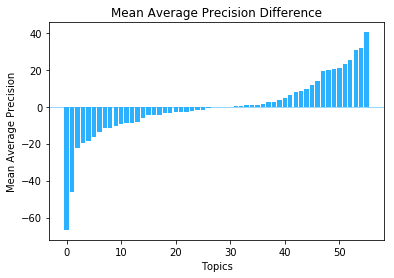

saving to opt/es-un-map-difference.png
saving to opt/es-un-map-difference.svg
['161' '-66.66666667000001']
['158' '40.277777775972226']


In [81]:
def _compare_print_table(str_data):
    print(tabulate(str_data, headers=('id', 'ap1', 'ap2', 'diff'), floatfmt='.2f'))

def _compare_plot(a_diff):
    fig, ax = fig_before('Mean Average Precision Difference', 'Topics', 'Mean Average Precision')
    ax.bar(range(a_diff.shape[0]), a_diff, color=CLR['blue'][2])
    ax.axhline(lw=0.5, color=CLR['blue'][2])
    fig_after(fig, ax, fname='es-un-map-difference')

def compare(exp1, exp2):
    topics = []
    difference = []
    
    print('exp1 map:', exp1.mean_avg_precision * 100)
    print('exp2 map:', exp2.mean_avg_precision * 100)
    print('diff:', exp2.mean_avg_precision * 100 - exp1.mean_avg_precision * 100)
    
    for top_id in exp1.stats:
        topics.append(top_id.split('-')[0])
        
        map1 = exp1.stats[top_id].avg_precision
        map2 = exp2.stats[top_id].avg_precision
        
        difference.append((map1, map2))
    
    a_maps = np.array(difference) * 100
    a_diff = a_maps[:, 1] - a_maps[:, 0]
    
    idx = np.argsort(a_diff)
    
    print('calc difference: ', a_diff.sum() / len(a_diff))
    
    str_data = np.vstack((np.array(topics), a_diff)).T[idx]
    a_data = a_diff[idx]
    
    _compare_print_table(str_data)
    _compare_plot(a_diff[idx])
    
    print(str_data[0])
    print(str_data[-1])

compare(exp_elastic, exp_ungol)

In [27]:
t_158 = common.Topic.from_es(es_client, '158-AH')

t_158_correct_ids = _get_correct_docs('158-AH')
print(t_158_correct_ids)
print(str(t_158))

for doc_id in t_158_correct_ids:
    print(str(report['158-AH'][doc_id]))
    print('=' * 120)

['SDA.950216.0150', 'SDA.950217.0028', 'SPIEGEL9495-007990']
[158-AH] Fußball-Rowdys in Dublin
- Description: Finde Berichte über den Abbruch des internationalen Fußballspiels zwischen Irland und England in Dublin nach Ausschreitungen.
- Narrative: Nach Ausschreitungen von Fußball-Hooligans wurde das internationale Fußballspiel Irland-England in Dublin abgebrochen, als die Iren mit 1:0 in der 27. Spielminute in Führung gingen.


rhwmd score : 1.5799107032469546

--------  ---
strategy  SUM
--------  ---



+----------------------------------------------------------------------------------------------------------+
|                                                                                                          |
|  comparing: "158-AH" to "SDA.950216.0150"                                                                |
|                                                                                                          |
|  -----  --------                                  


rhwmd score : 1.6159538429498728

--------  ---
strategy  SUM
--------  ---



+--------------------------------------------------------------------------------------------------------+
|                                                                                                        |
|  comparing: "158-AH" to "SPIEGEL9495-007990"                                                           |
|                                                                                                        |
|  -----  --------                                                                                       |
|  score  0.933899                                                                                       |
|  -----  --------                                                                                       |
|                                                                                                        |
|                                                               